In [21]:
import pandas as pd
import numpy as np
import arch, requests, zipfile, io
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf



In [35]:
# Download file and read into pandas data frame

url = "https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices.zip"

r = requests.get(url)
zf = zipfile.ZipFile(io.BytesIO(r.content))
data = pd.read_csv(zf.open("oxfordmanrealizedvolatilityindices.csv"), index_col=0)

In [36]:
print(data.columns.to_list())

['Symbol', 'bv', 'rk_parzen', 'rk_th2', 'rv5_ss', 'close_time', 'rv5', 'rsv', 'rk_twoscale', 'rv10_ss', 'close_price', 'medrv', 'rsv_ss', 'open_time', 'nobs', 'open_to_close', 'rv10', 'open_price', 'bv_ss']


In [24]:
print(data.Symbol.unique())

['.AEX' '.AORD' '.BFX' '.BSESN' '.BVLG' '.BVSP' '.DJI' '.FCHI' '.FTMIB'
 '.FTSE' '.GDAXI' '.GSPTSE' '.HSI' '.IBEX' '.IXIC' '.KS11' '.KSE' '.MXX'
 '.N225' '.NSEI' '.OMXC20' '.OMXHPI' '.OMXSPI' '.OSEAX' '.RUT' '.SMSI'
 '.SPX' '.SSEC' '.SSMI' '.STI' '.STOXX50E']


In [25]:
# Here we will use Stoxx50 

symbol = ".STOXX50E"

data_subset = data[data["Symbol"] == symbol]
data_subset = data_subset.loc[:, ["close_price", "rv5"]]
data_subset["log_return"] = np.log(data_subset["close_price"]) - np.log(data_subset["close_price"].shift(1))

# create absolute and squared log-return series
data_subset["abs_return"] = np.abs(data_subset["log_return"])
data_subset["squared_return"] = np.square(data_subset["log_return"])


## 1: Volatility measures
Plot different measures of volatility:
* absolute returns
* squared returns
* realized volatility (RV)

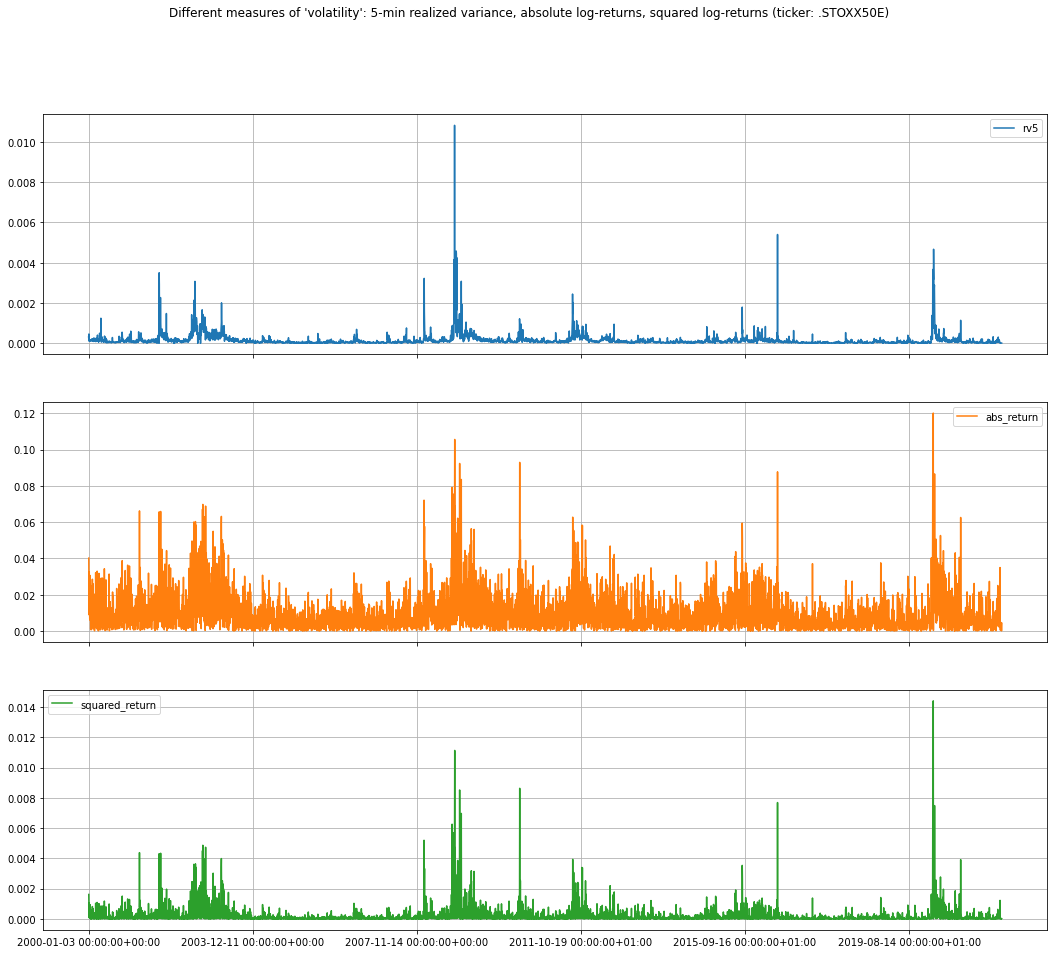

In [26]:


data_subset.loc[:, ["rv5", "abs_return", "squared_return"]].plot(title=f"Different measures of 'volatility': 5-min realized variance, absolute log-returns, squared log-returns (ticker: {symbol})",
                                                                 figsize=[18,15], subplots=True, grid=True)
plt.show()




## Volatility clustering

- Plot autocorrelograms of log, absolute and squared returns to inspect your data visually.
- What do you notice?


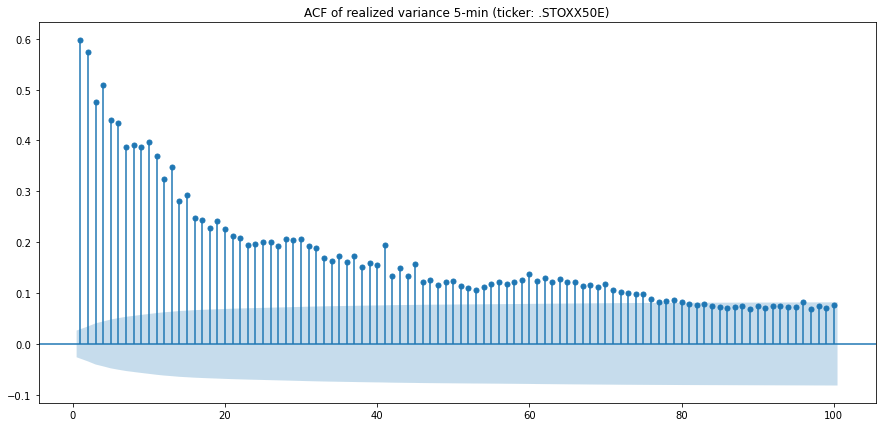

In [27]:
plt.rcParams['figure.figsize'] = [15, 7]

plot_acf(data_subset["rv5"], zero=False, lags=100, title= f"ACF of realized variance 5-min (ticker: {symbol})")
plt.show()



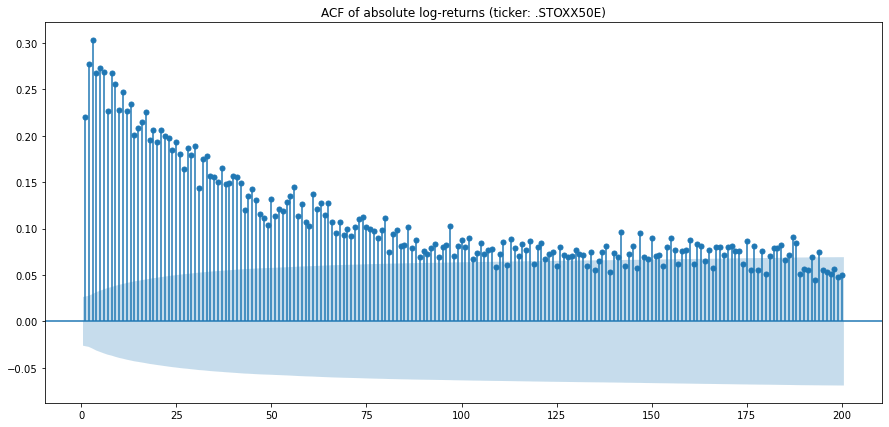

In [28]:
plot_acf(data_subset["abs_return"][1::], zero=False, lags=200, title=f"ACF of absolute log-returns (ticker: {symbol})")
plt.show()



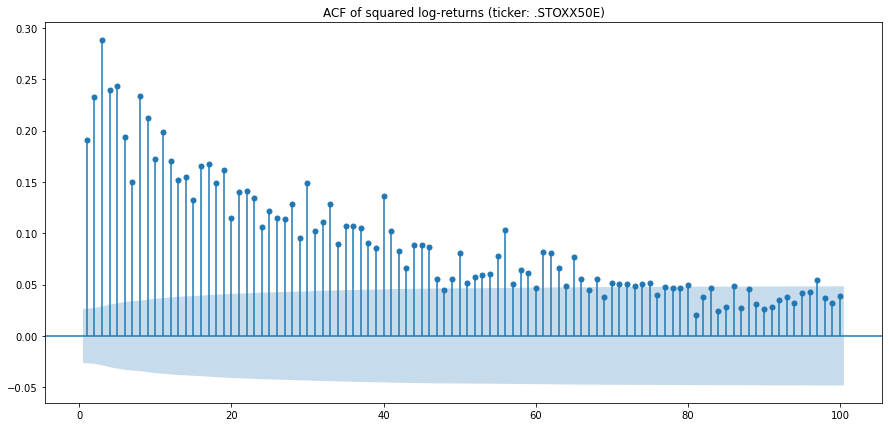

In [29]:
plot_acf(data_subset["squared_return"][1::], zero=False, lags=100, title=f"ACF of squared log-returns (ticker: {symbol})")
plt.show()

### Observations: 
- The empirical autocorrelation function decsays slowing for realiced variance, squared log-returns and absoulte log-returns. This suggestes a autoregressive component in these time series.
- The highest autocorrelation is obvserved for the first lag of the realized variance series at 0.6 for the first lag. i.e. high intraday variance today will result in high intraday price variation over the next couple of days!
- The squared and absolute log-returns start with a autocorrelation of about 0.2 - 0.3 for the first few lags
- It takes about 80 lags for the realized variance and squared return autocorrelation function to decay below the bartlett confidence intervall bounds

## Estimate a GARCH(1,1) model

A useful package for estimating volatility models in python is the Arch package. Documentation can be found here: https://arch.readthedocs.io/en/latest/univariate/introduction.html

In [45]:
am = arch.arch_model(data_subset["log_return"][1::] * 100, )
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 210792972701251.28
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3081750343.566206
Iteration:      3,   Func. Count:     23,   Neg. LLF: 11979.973748295157
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8908.593444424641
Iteration:      5,   Func. Count:     36,   Neg. LLF: 8845.66857964691
Iteration:      6,   Func. Count:     42,   Neg. LLF: 8999.143577176661
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8829.192976777005
Iteration:      8,   Func. Count:     54,   Neg. LLF: 8829.12465895163
Iteration:      9,   Func. Count:     60,   Neg. LLF: 8828.398011004698
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8828.397963526651
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8828.397963527019
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8828.397963526651
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11

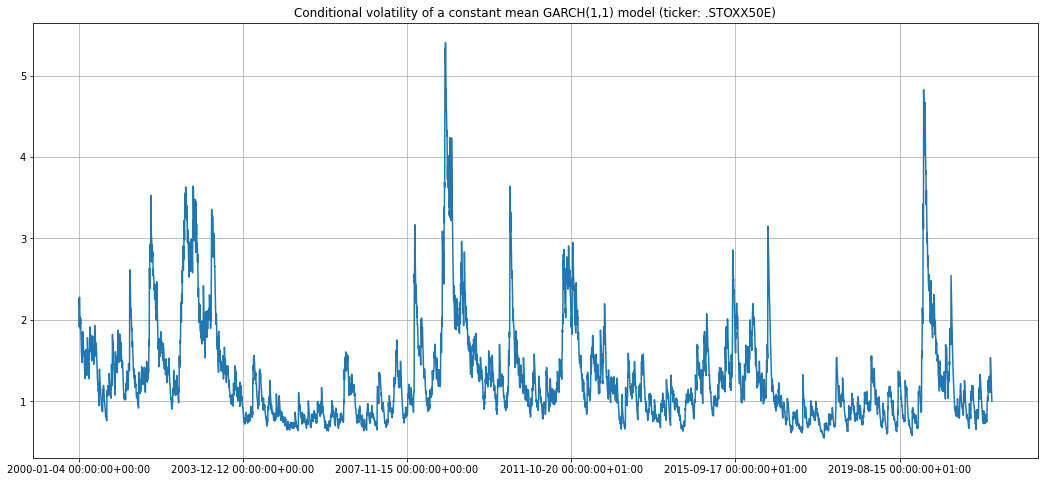

5-day analytical cond. volatility forecast using GARCH(1,1)
                                h.1      h.2       h.3       h.4       h.5
2021-11-18 00:00:00+00:00  0.933738  0.94835  0.962781  0.977033  0.991107


In [57]:

cond_vola_garch11 = res.conditional_volatility 
cond_vola_garch11.plot(title=f"Conditional volatility of a constant mean GARCH(1,1) model (ticker: {symbol})",
                                                           figsize=[18,8], grid=True)
plt.show()

forecasts = res.forecast(horizon=5, reindex=False)
print("5-day analytical cond. volatility forecast using GARCH(1,1)")
print(forecasts.residual_variance.dropna().head())

## 3. Distributional properties
a)	Plot the kernel density estimate of returns, standardized with its mean and variance ($\frac{r_t}{\sigma}$), and standardized with it realized standard deviation ($\bar{r_t}=\frac{r_t}{\sqrt{v_t}}$). Add a plot of the standard normal distribution for comparison.

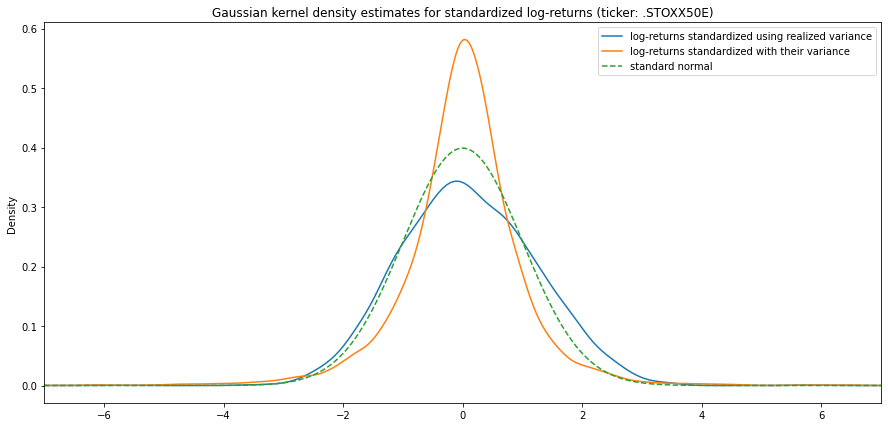

In [32]:
mu = np.mean(data_subset["log_return"][1::])
std = np.std(data_subset["log_return"][1::])

sta_return = (data_subset["log_return"][1::] - mu ) / std
sta_rv_return = (data_subset["log_return"][1::] - mu ) / np.sqrt(data_subset["rv5"][1::])

def normal_density(x, mu, sigma):
    fx = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x-mu)/sigma)**2)
    return fx

sta_rv_return.plot.density(bw_method="scott")
sta_return.plot.density(bw_method="scott")
x = np.linspace(-7, 7, 5000)
plt.plot(x, normal_density(x, 0, 1), linestyle='dashed') 

plt.title(f"Gaussian kernel density estimates for standardized log-returns (ticker: {symbol})")
plt.xlim([-7, 7])
plt.legend(["log-returns standardized using realized variance", "log-returns standardized with their variance", "standard normal"])
plt.show()



### Observation:
- log-returns stan#ardized with their corresponding realized variance seem to fit the standard normal distribution fairly well

b) Plot the kernel density estimate of realized standard deviation, realized logarithmic standard deviation, and a standard normal distribution. Standardize both distributions to make them better comparable with the standard normal.

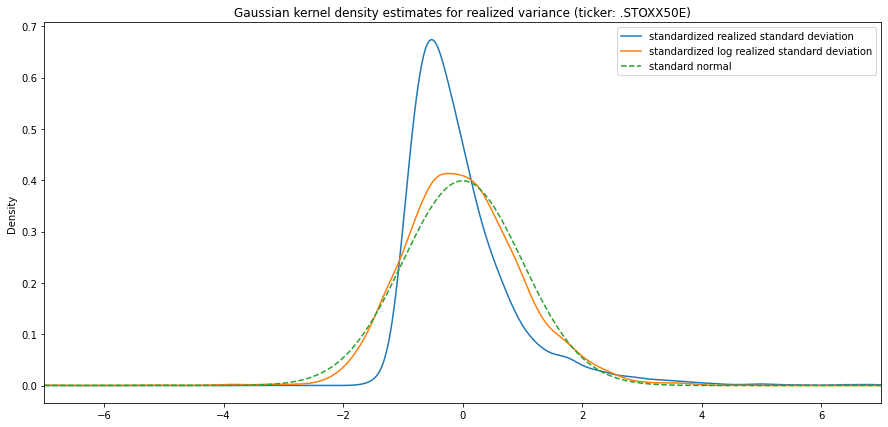

In [33]:
rstd = np.sqrt(data_subset["rv5"][1::])

log_rstd = np.log(rstd)
rstd_sta = (rstd - np.mean(rstd)) / np.std(rstd)
log_rstd_sta = (log_rstd - np.mean(log_rstd)) / np.std(log_rstd)

rstd_sta.plot.density(bw_method="scott")
log_rstd_sta.plot.density(bw_method="scott")
x = np.linspace(-7, 7, 5000)
plt.plot(x, normal_density(x, 0, 1), linestyle='dashed') 

plt.title(f"Gaussian kernel density estimates for realized variance (ticker: {symbol})")
plt.xlim([-7, 7])
plt.legend(["standardized realized standard deviation", "standardized log realized standard deviation", "standard normal"])
plt.show()


### Oberservation:
- Realized standard deviations (square root of the realized variance) appear to be approximately log-normally distributed 